In [2]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

stockStartDate = '2013-01-01'
today = datetime.today().strftime('%Y-%m-%d')
today

'2021-11-23'

In [4]:
df = pd.DataFrame()

for stock in assets:
    df[stock] = web.DataReader(stock, data_source='yahoo', start=stockStartDate, end=today)['Adj Close']

df

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,28.000000,257.309998,16.960690,13.144286,360.274597
2013-01-03,27.770000,258.480011,16.746618,13.798571,360.483826
2013-01-04,28.760000,259.149994,16.280140,13.711429,367.607117
2013-01-07,29.420000,268.459991,16.184372,14.171429,366.003143
2013-01-08,29.059999,266.380005,16.227934,13.880000,365.280823
...,...,...,...,...,...
2021-11-16,342.959991,3540.699951,151.000000,687.400024,2981.520020
2021-11-17,340.769989,3549.000000,153.490005,691.690002,2981.239990
2021-11-18,338.690002,3696.060059,157.869995,682.020020,3014.179932


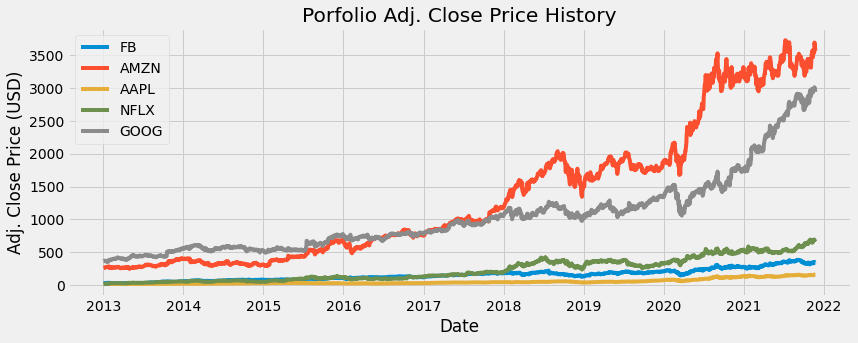

In [5]:
title = 'Porfolio Adj. Close Price History'
my_stocks = df

plt.figure(figsize=(12.5, 4.6))

for c in my_stocks.columns.values:
    plt.plot(my_stocks[c], label=c)

plt.title(title)
plt.xlabel("Date")
plt.ylabel("Adj. Close Price (USD)")
plt.legend(my_stocks.columns.values, loc="upper left")
plt.show()

In [6]:
returns = df.pct_change()
returns

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012622,0.049777,0.000581
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,0.019760
2013-01-07,0.022949,0.035925,-0.005883,0.033549,-0.004363
2013-01-08,-0.012237,-0.007748,0.002692,-0.020565,-0.001974
...,...,...,...,...,...
2021-11-16,-0.013235,-0.001405,0.006667,0.011879,-0.002089
2021-11-17,-0.006386,0.002344,0.016490,0.006241,-0.000094
2021-11-18,-0.006104,0.041437,0.028536,-0.013980,0.011049


In [7]:
cov_matrix_annual = returns.cov()*252
cov_matrix_annual

,FB,AMZN,AAPL,NFLX,GOOG
FB,0.115346,0.053103,0.043975,0.054764,0.049310
AMZN,0.053103,0.090611,0.039394,0.060488,0.046249
AAPL,0.043975,0.039394,0.079511,0.034879,0.037839
NFLX,0.054764,0.060488,0.034879,0.200388,0.047094
GOOG,0.049310,0.046249,0.037839,0.047094,0.065085


In [8]:
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.05940521416985565

In [9]:
port_volitility = np.sqrt(port_variance)
port_volitility

0.24373184890337096

In [10]:
portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights)*252
portfolioSimpleAnnualReturn

0.3559374032731099

In [11]:
percent_var = str(round(port_variance, 2)*100) + '%'
percent_vols = str(round(port_volitility, 2)*100) + '%'
percent_ret = str(round(portfolioSimpleAnnualReturn, 2)*100) + '%'

print('Expected Annual return: ' + percent_ret)
print('Annual Volitility/Risk: '+ percent_vols)
print('Annual Variance: ' + percent_var)

Expected Annual return: 36.0%
Annual Volitility/Risk: 24.0%
Annual Variance: 6.0%


In [12]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [13]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('FB', 0.08851), ('AMZN', 0.23255), ('AAPL', 0.28368), ('NFLX', 0.33401), ('GOOG', 0.06125)])
Expected annual return: 39.2%
Annual volatility: 26.2%
Sharpe Ratio: 1.42


(0.39194310576713726, 0.2621692657418676, 1.4187136112794898)

In [14]:
0.08851 + 0.23255 + 0.28368 + 0.33401 + 0.06125

1.0

In [19]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 10000)

allocation, leftover = da.greedy_portfolio()

allocation
print("Discrete Allocation: " + str(allocation))
print('Funds Remaining: ${:.2f}'.format(leftover))

Discrete Allocation: {'NFLX': 5, 'AAPL': 17, 'FB': 3, 'GOOG': 1}
Funds Remaining: $2.06
